### Biblioteki

In [1]:
from random import uniform
from queue import Queue
%matplotlib notebook

### Narzędzie graficzne

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.10


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

def test():

    print('halo')


# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling=True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling=False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling=False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling=False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (
                        np.mean([self.ax.get_xlim(), self.ax.get_ylim()]) * TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling=False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling=True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points = points
        self.lines = lines


# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points


# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes=[Scene()], points=[], lines=[], json=None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines": [linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

        # Metoda ta zwraca punkty dodane w trakcie rysowania.

    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines + self.callback.added_rects)
        else:
            return None

    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on=False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()


### Funkcje

In [3]:
# Zczytywanie punktów z Plot'u

def plot_to_points(p):
    
    points =  p.scenes[0].points[0].points
    
    return [Point(points[i][0], points[i][1]) for i in range(len(points))]

# Obliczanie wyznaczników

def orient(a, b, c):
    
    tol = 10 ** (-13)
    
    det = a.x * b.y + a.y * c.x + b.x*c.y - (b.y * c.x + a.x * c.y + a.y * b.x)
    
    if det > tol:
        return 1
    
    if det < -tol:
        return -1
    
    return 0
    
# Tworzenie początkowego prostokąta

def make_initial_rectangle(p):
    
    min_x = min(p, key=lambda point: point.x).x
    max_x = max(p, key=lambda point: point.x).x
    min_y = min(p, key=lambda point: point.y).y
    max_y = max(p, key=lambda point: point.y).y
    
    diff_x = (max_x - min_x) / 10
    diff_y = (max_y - min_y) / 10
    
    min_x -= diff_x
    max_x += diff_x
    min_y -= diff_y
    max_y += diff_y
    
    width = max_x - min_x
    height = max_y - min_y
    
    upper_left = Point(min_x, max_y)
    upper_right = Point(max_x, max_y)
    lower_left = Point(min_x, min_y)
    lower_right = Point(max_x, min_y)
    
    upper_left.setTrueCoordinates(min_x - 3 * width, max_y + 3 * height)
    upper_right.setTrueCoordinates(max_x + 3 * width, max_y + 3 * height)
    lower_left.setTrueCoordinates(min_x - 3 * width, min_y - 3 * height)
    lower_right.setTrueCoordinates(max_x + 3 * width, min_y - 3 * height)
    
    return [upper_left, upper_right, lower_left, lower_right]

# Generowanie pomocniczych trójkątów

def createTemporaryTriangles(rect):
    
    lines = []
    # górny i lewy bok prostokąta
    lines.append(Line(rect[0], rect[1]))
    lines.append(Line(rect[0], rect[2]))
    # przekątna prostokąta
    lines.append(Line(rect[1], rect[2]))
    # prawy i dolny bok prostokąta
    lines.append(Line(rect[1], rect[3]))
    lines.append(Line(rect[2], rect[3]))
    
    # tworzenie początkowych trójkątów
    triangle1 = Triangle(lines[0], lines[1], lines[2])
    triangle2 = Triangle(lines[2], lines[3], lines[4])\
    
    return triangle2

# Obliczanie odległości pomiędzy dwoma punktami

def dist(p1, p2):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

# Odnajdywanie trójkąta, w którym znajduje się zadany punkt

def findTriangle(point, triangle):
    
    direction = -1
    
    for i in range(3):
        if triangle.findDirection(i, point):
            direction = i
            
    if direction == -1:
        return triangle
    
    else:
        return findTriangle(point, triangle.getNeighbor(direction))    
    
# Funkcja sprawdza czy punkt leży na boku trójkąta

def belongingLineIndex(triangle, point):
    line1 = triangle.lines[0]
    line2 = triangle.lines[1]
    line3 = triangle.lines[2]
    
    if orient(line1.p1, line1.p2, point) == 0:
        return 0
    if orient(line2.p1, line2.p2, point) == 0:
        return 1
    if orient(line3.p1, line3.p2, point) == 0:
        return 2
    return None


    %matplotlib notebook

# Generowanie zbiorów losowych punktów

def random_points(n, a, b):
    T = [Point(uniform(a,b), uniform(a,b)) for _ in range(n)]
    
    return T

# Ustawianie wartości visited wszystkich trójkątów na false 

def unvisitTriangles(triangle):
    
    q = Queue()
    q.put(triangle)
    
    while not q.empty():
        currentTriangle = q.get()
        
        if currentTriangle.visited == False:
            continue
            
        if currentTriangle is not None:
            
            for line in currentTriangle.lines:
                nextTriangle = line.getNeighborOf(currentTriangle)

                if nextTriangle is not None and nextTriangle.visited:
                    q.put(nextTriangle)

            currentTriangle.visited = False

# Tłumaczenie struktury triangulacji na listę odcinków

def createLinesArray(triangle):
    
    lines = []
    q = Queue()
    q.put(triangle)

    while not q.empty():
        currentTriangle = q.get()
        
        if currentTriangle.visited == True:
            continue
        
        for line in currentTriangle.lines:
            nextTriangle = line.getNeighborOf(currentTriangle)

            if nextTriangle is None:
                lines.append(line.toVArray())

            elif not nextTriangle.visited:
                lines.append(line.toVArray())
                q.put(nextTriangle)

        currentTriangle.visited = True

    q.put(triangle)

    unvisitTriangles(triangle)
        
    return lines
        
# Tłumaczenie struktury triangulacji na listę trójkątów

def createTrianglesArray(triangle):
    
    triangles = []
    q = Queue()
    q.put(triangle)

    while not q.empty():
        currentTriangle = q.get()        
        if currentTriangle.visited == True:
            continue
        triangles.append(currentTriangle)

        for line in currentTriangle.lines:
            nextTriangle = line.getNeighborOf(currentTriangle)
            if nextTriangle is not None:
                q.put(nextTriangle)

        currentTriangle.visited = True

    q.put(triangle)

    unvisitTriangles(triangle)
        
    return triangles

# Zamiana nielegalnych krawędzi na legalne w pierwszej metodzie triangulacji

def beautifyTriangles(triangle, currPoint):
    neighborTriangle = triangle.getNeighbor(2)
    if neighborTriangle is not None:
        mid, r = neighborTriangle.findCircle()
        if dist(mid, currPoint) < r:
            line1 = triangle.lines[0]
            line2 = triangle.lines[1]
            # ta linia jest wspolna
            line3 = triangle.lines[2]
            
            if line3 == neighborTriangle.lines[0]:
                line4 = neighborTriangle.lines[1]
                line5 = neighborTriangle.lines[2]
                fourthVertex = neighborTriangle.opposite(0)
            elif line3 == neighborTriangle.lines[1]:
                line4 = neighborTriangle.lines[0]
                line5 = neighborTriangle.lines[2]
                fourthVertex = neighborTriangle.opposite(1)
            else:
                line4 = neighborTriangle.lines[0]
                line5 = neighborTriangle.lines[1]
                fourthVertex = neighborTriangle.opposite(2)
            
            triangle.remove()
            neighborTriangle.remove()
            
            newLine = Line(fourthVertex, currPoint)
            if line1.contains(line4.p1) or line1.contains(line4.p2):
                rotatedTriangle1 = Triangle(newLine, line1, line4)
                rotatedTriangle2 = Triangle(newLine, line2, line5)
            else:
                rotatedTriangle1 = Triangle(newLine, line1, line5)
                rotatedTriangle2 = Triangle(newLine, line2, line4)
            return rotatedTriangle1, [line1.toArray(), line2.toArray(), line4.toArray(), line5.toArray()]
                    
    return triangle, [triangle.lines[0].toArray(), triangle.lines[1].toArray(), triangle.lines[2].toArray()]

# Usuwanie pomocniczych punktów

def removeTemporaryLines(lines, initialRectangle, usedPoints):

    toRemove = []
    for line in lines:
        for point in initialRectangle:
            if line[0] == point.toArray() or line[1] == point.toArray():
                toRemove.append(line)
                break
    
    for line in toRemove:
        lines.remove(line)
    for point in initialRectangle:
        usedPoints.remove(point)

# Funkcja partition z quick sorta dla sosrtowania odcinków

def partition(boundaries, point, l, r):
    i = l - 1
    pivot = boundaries[r].middle()
    if orient(point, boundaries[r].p1, boundaries[r].p2) < 0:
        boundaries[r].p1, boundaries[r].p2 = boundaries[r].p2, boundaries[r].p1
    
    for j in range(l, r):
        if orient(point, boundaries[j].p1, boundaries[j].p2) < 0:
            boundaries[j].p1, boundaries[j].p2 = boundaries[j].p2, boundaries[j].p1

        if orient(point, pivot, boundaries[j].middle()) < 0:
            i += 1
            boundaries[i], boundaries[j] = boundaries[j], boundaries[i]
    
    i += 1
    boundaries[i], boundaries[r] = boundaries[r], boundaries[i]

    return i

# Funkcja sortująca odcinki na podstawie kąta pomiędzy osią x, a prostą przechodzącą przez ich środki i zadany punkt

def sortBoundaries(boundaries, point, l, r):
    if l < r:
        q = partition(boundaries, point, l, r)
        sortBoundaries(boundaries, point, l, q - 1)
        sortBoundaries(boundaries, point, q + 1, r)

# Wizualizacja odnajdywania trójkąta w struktórze

def findingTriangleVisualization(p, visualize = True):
    # tworzymy prostokąt, który zawiera we wnętrzu wszystkie punkty chmury
    initialRectangle = make_initial_rectangle(p)
    # Trójkąt startowy
    firstTriangle = createTemporaryTriangles(initialRectangle.copy())
    
    usedPoints = initialRectangle.copy()
    
    scenes = []

    # Główna pętla algorytmu, w której przechodzimy po punktach
    for i in range(len(p) - 1):
        currPoint = p[i]
        #Znajduje trójkąt, w którym znajduje się punkt, jeżeli jest na linii to znajduje dowolny z tych do których linia należy
        currentTriangle = findTriangle(currPoint, firstTriangle)
        triangleVertexes = [currentTriangle.lines[0].p1, currentTriangle.lines[0].p2, currentTriangle.opposite(0)]
        
        
        newTriangles = []
        line1 = currentTriangle.lines[0]
        line2 = currentTriangle.lines[1]
        line3 = currentTriangle.lines[2]
            
        # łącze znalezione wierzcholki z dodanym
        newLine1 = Line(triangleVertexes[0], currPoint)
        newLine2 = Line(triangleVertexes[1], currPoint)
        newLine3 = Line(triangleVertexes[2], currPoint)

            
        currentTriangle.remove()

        Triangle1 = Triangle(newLine1, newLine2, line1)
        if line2.contains(line1.p1):
            Triangle2 = Triangle(newLine3, newLine1, line2)
            Triangle3 = Triangle(newLine3, newLine2, line3)
        else:
            Triangle2 = Triangle(newLine3, newLine2, line2)
            Triangle3 = Triangle(newLine3, newLine1, line3)

                
        newTriangles += [Triangle1, Triangle2, Triangle3]
        firstTriangle = Triangle1         
            
        for triangle in newTriangles:
            firstTriangle, rectangle = beautifyTriangles(triangle, currPoint)
        
        usedPoints.append(currPoint)
        
    searchPoint = p[len(p) - 1]
    scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([searchPoint.toArray()], color = 'red')],
                            [LinesCollection(createLinesArray(firstTriangle).copy())])) 
    
    def findTriangleVis(point, triangle):
        nonlocal scenes
        
        scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([searchPoint.toArray()], color = 'red')],
                            [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([triangle.lines[0].toArray(), triangle.lines[1].toArray(), triangle.lines[2].toArray()], color = 'green')])) 
    
        direction = -1
        for i in range(3):
            scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([searchPoint.toArray()], color = 'red')],
                            [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([triangle.lines[i].toArray()], color = 'red')])) 
    
            if triangle.findDirection(i, point):
                scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([searchPoint.toArray()], color = 'red')],
                            [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([triangle.lines[i].toArray()], color = 'green')])) 
    
                direction = i
                break
        if direction == -1:
            return triangle
        else:
            return findTriangleVis(point, triangle.getNeighbor(direction))
     
    finalTriangle = findTriangleVis(searchPoint, firstTriangle)
    scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([searchPoint.toArray()], color = 'red')],
                            [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([finalTriangle.lines[0].toArray(), finalTriangle.lines[1].toArray(), finalTriangle.lines[2].toArray()], color = 'red')])) 
    
        
    
    return scenes

### Klasy

In [4]:
class Point:
    
    def __init__(self, x, y):
        
        self.x = x
        self.y = y
        self.vx = x
        self.vy = y
        
    def setTrueCoordinates(self, x, y):
        self.x = x
        self.y = y
        
    def __eq__(self, other):
        
        return self.x == other.x and self.y == other.y

    def __qt__(self, other):
        if self.x != other.x:
            return self.x > other.x
        else:
            return self.y > other.y

    def __str__(self) -> str:
        return "[" + str(self.x) + ", " + str(self.y) + "]"

    def toArray(self):
        return [self.vx, self.vy]
    
    def toVArray(self):
        return [self.vx, self.vy]
    
    
class Line:
    
    def __init__(self, p1, p2):
        
        self.p1 = p1
        self.p2 = p2
        self.t1 = None
        self.t2 = None
        
    def addTriangle(self, triangle):
        
        if self.t1 == None:
            
            self.t1 = triangle
            
        elif self.t2 == None:
            
            self.t2 = triangle
            
        else:
            print('probujesz dodac trojkat do linii o dwoch sasiadach')
            return False
        
    def removeTriangle(self, triangle):
        
        if triangle == self.t1:
            
            self.t1 = None
            
        elif triangle == self.t2:
            
            self.t2 = None
    
    def middle(self):
        return Point((self.p1.x + self.p2.x) / 2, (self.p1.y + self.p2.y) / 2)

    def contains(self, point):
        
        if self.p1 == point or self.p2 == point:
            
            return True
        
        return False
    
    def replaceTriangle(self, oldTriangle, newTriangle):
        
        self.removeTriangle(oldTriangle)
        self.addTriangle(newTriangle)
        
    def getNeighborOf(self, triangle):
            
        if self.t1 == triangle:    
            
            return self.t2
        
        elif self.t2 == triangle:
            
            return self.t1
        
        return False
            
    def __eq__(self, other):
        return self.p1 == other.p1 and self.p2 == other.p2

    def __str__(self) -> str:
        return "[" + str(self.p1) + ", " + str(self.p2) + "]"
    
    def toArray(self):
        return [self.p1.toArray(), self.p2.toArray()]
    
    def toVArray(self):
        return [self.p1.toVArray(), self.p2.toVArray()]

    def getTriangle(self):
        if self.t1 is None:
            return self.t2
        else:
            return self.t1

    def findBisector(self):
        x1 = self.p1.x
        x2 = self.p2.x
        y1 = self.p1.y
        y2 = self.p2.y
        
        if y1 == y2:
            a = np.inf
            b = (x1 + x2) / 2
        else:
            a = (x2 - x1) / (y1 - y2)
            b = ((y1 + y2) - a * (x1 + x2)) / 2

        return a, b

    def findCircle(self, other):
        
        a1, b1 = self.findBisector()
        a2, b2 = other.findBisector()

        if a1 == np.inf:
            x = b1
            y = a2 * x + b2
        elif a2 == np.inf:
            x = b2
            y = a1 * x + b1
        else:
            x = (b1 - b2) / (a2 - a1)
            y = a1 * x + b1

        r = dist(self.p1, Point(x, y))

        return Point(x, y), r

    
class Triangle:
    
    def __init__(self, l1, l2, l3):
        
        self.visited = False
        self.lines = [l1, l2, l3]
        
        l1.addTriangle(self)
        l2.addTriangle(self)
        l3.addTriangle(self)

        
    def __eq__(self, other):
        
        if other is None:
            return False
        
        return self.lines[0] == other.lines[0] and self.lines[1] == other.lines[1] and self.lines[2] == other.lines[2]
    
    def remove(self):
        for line in self.lines:
            line.removeTriangle(self)
    
    def opposite(self, index):
        
        # ni = next index
        ni = (index + 1) % 3
        
        if self.lines[index].contains(self.lines[ni].p1):
            
            return self.lines[ni].p2
        
        return self.lines[ni].p1
    
    def findDirection(self, index, point):
        
        line = self.lines[index]
        p = self.opposite(index)
        
        return orient(line.p1, line.p2, p) + orient(line.p1, line.p2, point) == 0
        
        
    def getNeighbor(self, index):
        
        return self.lines[index].getNeighborOf(self)

    def __str__(self) -> str:
        return "line 1: " + str(self.lines[0]) + "\nline 2: " + str(self.lines[1]) + "\nline 3: " + str(self.lines[2])

    def findCircle(self):
        return self.lines[0].findCircle(self.lines[1])
        
    def getVertices(self):
        vertices = [self.lines[0].p1, self.lines[0].p2]
        if self.lines[1].p1 in vertices:
            vertices.append(self.lines[1].p2)
        else:
            vertices.append(self.lines[1].p1)
        return vertices

### Triangulacja 1 metodą

In [5]:
def triangulacjaDelaunaya1(p, visualize = True):
    # tworzymy prostokąt, który zawiera we wnętrzu wszystkie punkty chmury
    initialRectangle = make_initial_rectangle(p)
    # Trójkąt startowy
    firstTriangle = createTemporaryTriangles(initialRectangle.copy())
    
    usedPoints = initialRectangle.copy()
    
    scenes = []
    if visualize:
        scenes.append(Scene([PointsCollection([point.toArray() for point in p])]))
        scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints])],
                                [LinesCollection(createLinesArray(firstTriangle).copy())]))


    # Główna pętla algorytmu, w której przechodzimy po punktach
    for currPoint in p:
        if visualize:
            scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([currPoint.toArray()], color ='red')],
                                [LinesCollection(createLinesArray(firstTriangle).copy())]))

        #Znajduje trójkąt, w którym znajduje się punkt, jeżeli jest na linii to znajduje dowolny z tych do których linia należy
        currentTriangle = findTriangle(currPoint, firstTriangle)
        triangleVertexes = [currentTriangle.lines[0].p1, currentTriangle.lines[0].p2, currentTriangle.opposite(0)]
        
        
        newTriangles = []
        if belongingLineIndex(currentTriangle, currPoint) is None:
            line1 = currentTriangle.lines[0]
            line2 = currentTriangle.lines[1]
            line3 = currentTriangle.lines[2]
            
            # łącze znalezione wierzcholki z dodanym
            newLine1 = Line(triangleVertexes[0], currPoint)
            newLine2 = Line(triangleVertexes[1], currPoint)
            newLine3 = Line(triangleVertexes[2], currPoint)

            if visualize:
                scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([currPoint.toArray()], color ='red')],
                                    [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([line1.toArray(), line2.toArray(), line3.toArray()], color = 'green')]))


            currentTriangle.remove()

            Triangle1 = Triangle(newLine1, newLine2, line1)
            if line2.contains(line1.p1):
                Triangle2 = Triangle(newLine3, newLine1, line2)
                Triangle3 = Triangle(newLine3, newLine2, line3)
            else:
                Triangle2 = Triangle(newLine3, newLine2, line2)
                Triangle3 = Triangle(newLine3, newLine1, line3)

                
            newTriangles += [Triangle1, Triangle2, Triangle3]
            firstTriangle = Triangle1         
            
            if visualize:
                scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([currPoint.toArray()], color ='red')],
                                    [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([newLine1.toArray(), newLine2.toArray(), newLine3.toArray()], color = 'red')]))

        else:
            diagonalIndex = belongingLineIndex(currentTriangle, currPoint)
            line1 = currentTriangle.lines[(diagonalIndex + 1) % 3]
            line2 = currentTriangle.lines[(diagonalIndex + 2) % 3]
            
            # Przekątna
            line3 = currentTriangle.lines[diagonalIndex]
            
            if line2.contains(line3.p2):
                    line1, line2 = line2, line1
            newLine1 = Line(currentTriangle.opposite(diagonalIndex), currPoint)
            newLine2 = Line(line3.p1, currPoint)
            newLine3 = Line(line3.p2, currPoint)

            
            oppositeTriangle = currentTriangle.getNeighbor(diagonalIndex)
            
            if line3 == oppositeTriangle.lines[0]:
                line4 = oppositeTriangle.lines[1]
                line5 = oppositeTriangle.lines[2]
                lineIndex = 0
            elif line3 == oppositeTriangle.lines[1]:
                line4 = oppositeTriangle.lines[0]
                line5 = oppositeTriangle.lines[2]
                lineIndex = 1
            else:
                line4 = oppositeTriangle.lines[0]
                line5 = oppositeTriangle.lines[1]
                lineIndex = 2
                    
            if line5.contains(line3.p1):
                line4, line5 = line5, line4
            newLine4 = Line(oppositeTriangle.opposite(lineIndex), currPoint)
            
            if visualize:
                scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([currPoint.toArray()], color ='red')],
                                    [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([line1.toArray(), line2.toArray(), line4.toArray(), line5.toArray()], color = 'green')]))

            
            currentTriangle.remove() 
            oppositeTriangle.remove()
            
            Triangle1 = Triangle(newLine1, newLine3, line1)
            Triangle2 = Triangle(newLine1, newLine2, line2)
            Triangle3 = Triangle(newLine4, newLine2, line4)
            Triangle4 = Triangle(newLine4, newLine3, line5)
            
            newTriangles += [Triangle1, Triangle2, Triangle3, Triangle4]
            firstTriangle = Triangle1
            
            if visualize:
                scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([currPoint.toArray()], color ='red')],
                                    [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection([newLine1.toArray(), newLine2.toArray(), newLine3.toArray(), newLine4.toArray()], color = 'red')]))

        for triangle in newTriangles:
            firstTriangle, rectangle = beautifyTriangles(triangle, currPoint)
            
            if visualize:
                scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([currPoint.toArray()], color ='red')],
                                    [LinesCollection(createLinesArray(firstTriangle).copy()), LinesCollection(rectangle.copy(), color = 'green')]))


            
            
        usedPoints.append(currPoint)

        
    if visualize:  
        scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints])],
                                [LinesCollection(createLinesArray(firstTriangle).copy())])) 
        scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints]), PointsCollection([point.toArray() for point in initialRectangle], color = 'red')],
                                [LinesCollection(createLinesArray(firstTriangle).copy())]))

    lines = createLinesArray(firstTriangle)
    removeTemporaryLines(lines, initialRectangle, usedPoints)
    
    if visualize:
        scenes.append(Scene([PointsCollection([point.toArray() for point in usedPoints])],
                                [LinesCollection(lines)])) 

    
    return lines, scenes

### Triangulacja 2 metodą

In [6]:
def triangulacjaDelaunaya2(points, draw = True):
    
    initial_rectangle = make_initial_rectangle(points)
    firstTriangle = createTemporaryTriangles(initial_rectangle)    
    
    if draw:
        scenes = [Scene([], [LinesCollection(createLinesArray(firstTriangle))])]

    
    for point in points:
        centerTriangle = findTriangle(point, firstTriangle)
        q = []
        q.append(centerTriangle)
        trianglesToRemove = [centerTriangle]
        boundaries = []

        while len(q) > 0:
            currentTriangle = q.pop()
            if currentTriangle.visited:
                continue
            
            currentTriangle.visited = True
            for line in currentTriangle.lines:
                nextTriangle = line.getNeighborOf(currentTriangle)
                if nextTriangle is None:
                    boundaries.append(line)
                elif not nextTriangle.visited:
                    middle, r = nextTriangle.findCircle()
                    if dist(point, middle) < r:
                        q.append(nextTriangle)
                        trianglesToRemove.append(nextTriangle)
                    else:
                        boundaries.append(line)

        for triangle in trianglesToRemove:
            triangle.remove()

        sortBoundaries(boundaries, point, 0, len(boundaries) - 1)
        uniqueBoundaries = [boundaries[-1]]
        for i in range(len(boundaries) - 1):
            if boundaries[i] != boundaries[i + 1]:
                uniqueBoundaries.append(boundaries[i])

        diagonals = []
        for line in uniqueBoundaries:
            diagonals.append(Line(line.p1, point))
        
        n = len(uniqueBoundaries)
        for i in range(n):
            Triangle(uniqueBoundaries[i], diagonals[i], diagonals[(i + 1) % n])
        firstTriangle = diagonals[0].getTriangle()

        if draw:
            scenes.append(Scene([PointsCollection([[point.x, point.y]], color = 'red')], [LinesCollection(createLinesArray(firstTriangle))]))
        
    trianglesToRemove = []
    allTriangles = createTrianglesArray(firstTriangle)
    for triangle in allTriangles:
                vertices = triangle.getVertices()
                if vertices[0] in initial_rectangle or vertices[1] in initial_rectangle or vertices[2] in initial_rectangle:
                    trianglesToRemove.append(triangle)
    
    i = 0
    n = len(allTriangles)
    while i < n and allTriangles[i] in trianglesToRemove:
        i += 1
    firstTriangle = allTriangles[i]
    
    for triangle in trianglesToRemove:
        triangle.remove()
    
    if draw:
        scenes.append(Scene([PointsCollection([[initial_rectangle[i].vx, initial_rectangle[i].vy] for i in range(4)], color = 'white')], [LinesCollection(createLinesArray(firstTriangle))]))
        return (createLinesArray(firstTriangle), scenes)

### Rysowanie punktów

<IPython.core.display.Javascript object>


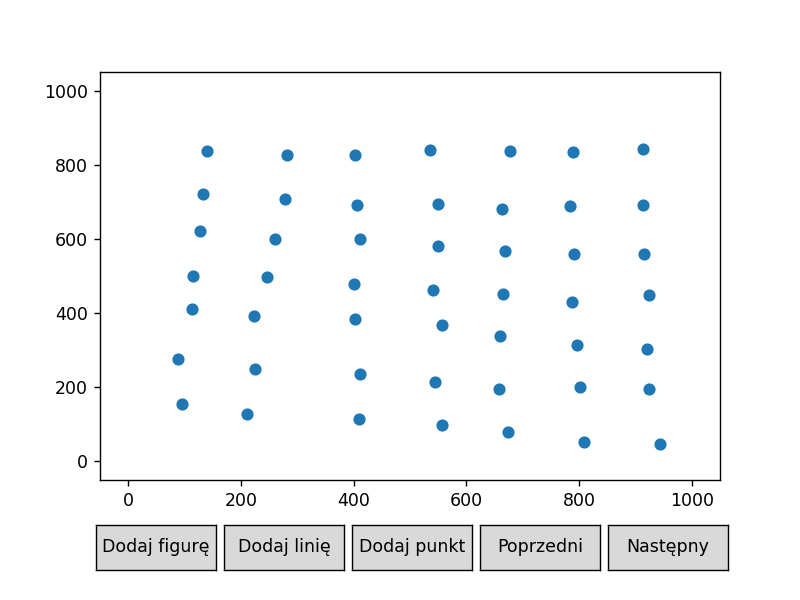

In [11]:
plot = Plot(points = [PointsCollection([(0, 0), (1000, 1000)], color = 'white')])
plot.draw()

### Zapis narysowanych punktów do pliku

In [12]:
fileName = 'tmp.json'

drawnPlot = Plot([plot.get_added_elements()])
with open(fileName, 'w') as file:
    file.write(drawnPlot.toJson())

### Zapisanie zbioru losowych punktów do pliku

In [9]:
fileName = 'random_points.json'
numberOfPoints = 10
rangeOfPoints = [-100, 100]

random = random_points(numberOfPoints, rangeOfPoints[0], rangeOfPoints[1])
res = [point.toArray() for point in random]
randomPlot = Plot(points = [PointsCollection(res)])

with open(fileName, 'w') as file:
   file.write(randomPlot.toJson())

### Odczyt punktów z pliku

<IPython.core.display.Javascript object>


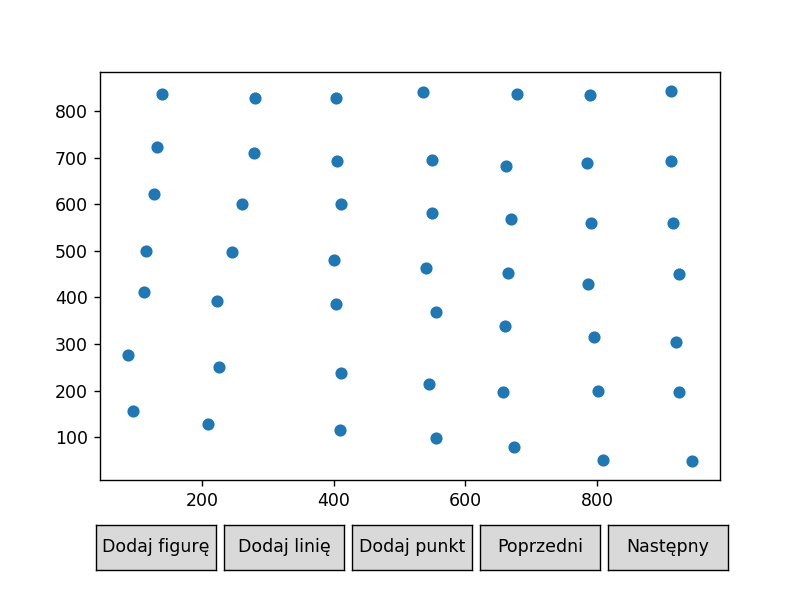

In [13]:
with open('tmp.json', 'r') as file:
    json = file.read()

tmp = Plot(json = json)
tmp.draw()

### Wizualizacja pierwszej metody triangulacji

Liczba odcinków:  124


<IPython.core.display.Javascript object>


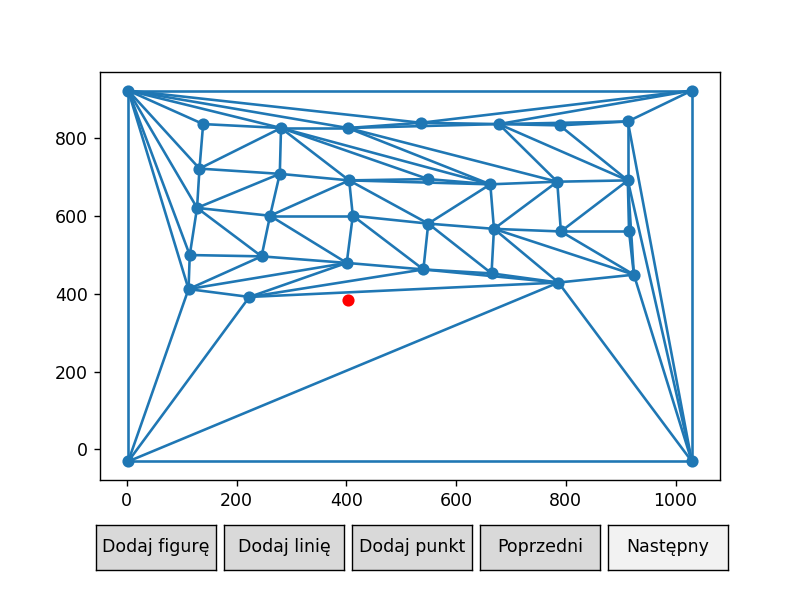

In [16]:
result = triangulacjaDelaunaya1(plot_to_points(tmp))
print('Liczba odcinków: ', len(result[0]))
plot = Plot(result[1])
plot.draw()

### Wizualizacja drugiej metody triangulacji

Liczba odcinków:  129


<IPython.core.display.Javascript object>


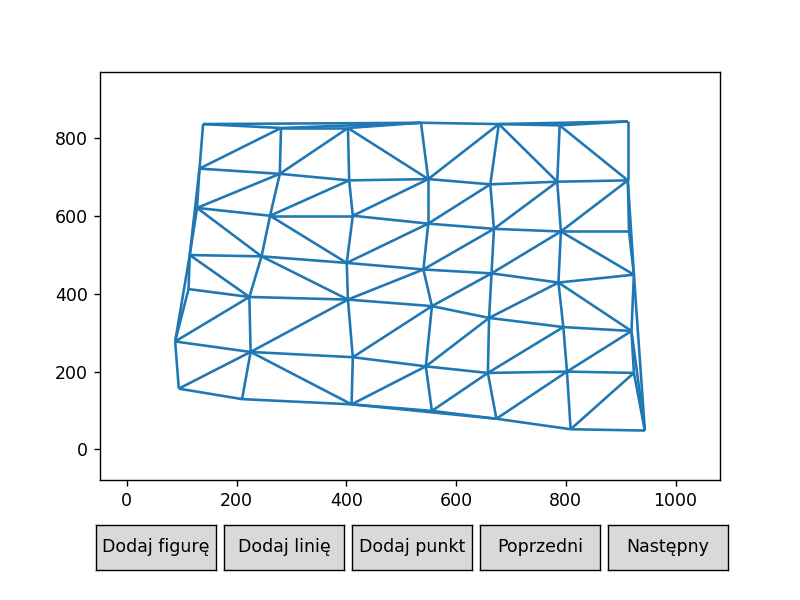

In [15]:
result = triangulacjaDelaunaya2(plot_to_points(tmp))
print('Liczba odcinków: ', len(result[0]))
plot = Plot(result[1])
plot.draw()

### Wizualizacja odnajdywania trójkąta

<IPython.core.display.Javascript object>


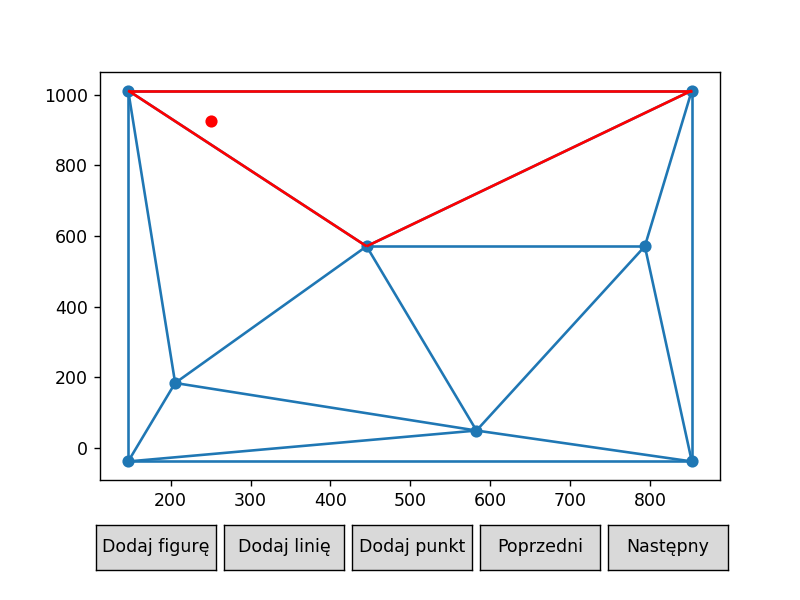

In [10]:
result = findingTriangleVisualization(plot_to_points(tmp))
plot = Plot(result)
plot.draw()

### Porównanie czasu wykonywania algorytmów

In [11]:
from time import time

numbersOfPoints = [10, 100, 200, 500, 1000, 2000, 5000, 10000]

for numberOfPoints in numbersOfPoints:
    points = random_points(numberOfPoints, -100, 100)
    print(numberOfPoints, 'punktów:')
    start = time()
    triangulacjaDelaunaya1(points, False)
    end = time()
    print('1 algorithm time: \t', end - start)
    start = time()
    triangulacjaDelaunaya2(points, False)
    end = time()
    print('2 algorithm time: \t', end - start, "\n")


10 punktów:
1 algorithm time: 	 0.0009968280792236328
2 algorithm time: 	 0.0019948482513427734 

100 punktów:
1 algorithm time: 	 0.03490877151489258
2 algorithm time: 	 0.04487800598144531 

200 punktów:
1 algorithm time: 	 0.04224443435668945
2 algorithm time: 	 0.062485456466674805 

500 punktów:
1 algorithm time: 	 0.20723772048950195
2 algorithm time: 	 0.2996833324432373 

1000 punktów:
1 algorithm time: 	 0.7496817111968994
2 algorithm time: 	 0.6477417945861816 

2000 punktów:
1 algorithm time: 	 1.0625331401824951
2 algorithm time: 	 1.2228100299835205 

5000 punktów:
1 algorithm time: 	 3.3899118900299072
2 algorithm time: 	 4.02090048789978 

10000 punktów:
1 algorithm time: 	 13.002050161361694
2 algorithm time: 	 16.798595905303955 

